Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import json
import re

from typing import List, Iterable, Tuple
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector
from scratch.deep_learning import DeepLearning as dl
from scratch.deep_learning import \
  Tensor, Layer, Sequential, Linear, SoftmaxCrossEntropy, Momentum, \
  GradientDescent

from scratch.working_with_data import DimReduction

In [17]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

## Word Vectors

A lot of recent advances in NLP involves deep learning. Now we turn our
model using deep learning machinery.

The idea of word vectors, we represent each word using low-dimensional
vectors. Using this representation we can compare, add, feed into machine
learning models, or anything else with other techniques.

In [2]:
# Use cosine similarity to measure the similarity between wor vectors
def cosine_similarity(v1: Vector, v2: Vector) -> float:
  return la.dot(v1, v2) / np.sqrt(la.dot(v1, v1) * la.dot(v2, v2)) 


print(cosine_similarity([1., 1., 1.], [2., 2., 2.]))       # same direction
print(cosine_similarity([-1., -1.], [2., 2.]))             # opposite direction
print(cosine_similarity([1.0, 0.], [0., 1.]))              # orthogonal

1.0
-1.0
0.0


Now let's learn using word vectors with toy datasets

In [3]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

seed = 2023_05
rng = np.random.default_rng(seed)
def make_sentence(rng) -> str:
  return " ".join([
    "The",
    rng.choice(colors),
    rng.choice(nouns),
    rng.choice(verbs),
    rng.choice(adverbs),
    rng.choice(adjectives),
    "."
  ])

NUM_SENTENCES = 50
sentences = [make_sentence(rng) for _ in range(NUM_SENTENCES)]
sentences

['The  bed seems extremely slow .',
 'The  cat was extremely hard .',
 'The black bed seems very soft .',
 'The  car was quite soft .',
 'The green bed was extremely fast .',
 'The black bed seems very soft .',
 'The green cat was  hard .',
 'The yellow bed was very fast .',
 'The green car was quite slow .',
 'The  cat is extremely slow .',
 'The yellow cat was quite slow .',
 'The green bed was quite soft .',
 'The red car is extremely soft .',
 'The blue boat was very slow .',
 'The red bed seems extremely hard .',
 'The green car is extremely soft .',
 'The red bed is very soft .',
 'The blue boat is quite hard .',
 'The green bed is extremely soft .',
 'The blue car seems  fast .',
 'The red car seems quite soft .',
 'The yellow car was  slow .',
 'The yellow car was very soft .',
 'The blue cat seems extremely slow .',
 'The blue bed is  fast .',
 'The red car was quite hard .',
 'The black boat was quite slow .',
 'The yellow car seems very hard .',
 'The green car was extremely

We want to do one-hot encoding using the following `Vocabulary` class

In [4]:
class Vocabulary(object):
  def __init__(self, words: List[str] = None) -> None:
    self.w2i: Dict[str, int] = {}   # mapping word -> word_id
    self.i2w: Dict[int, str] = {}   # mapping word_id -> word

    for word in (words or []):      # If words were provided
      self.add(word)                # add them.


  @property 
  def size(self) -> int:
    """how many words are in the vocabulary""" 
    return len(self.w2i)

  def add(self, word: str) -> None:
    if word not in self.w2i:        # If the word is new to us:
      word_id = len(self.w2i)       # Find the next id. 
      self.w2i[word] = word_id      # Add to the word -> word_id map. 
      self.i2w[word_id] = word      # Add to the word_id -> word map. 

  def get_id(self, word: str) -> int: 
    """return the id of the word (or None)""" 
    return self.w2i.get(word)

  def get_word(self, word_id: int) -> str:
    """return the word with the given id (or None)""" 
    return self.i2w.get(word_id)

  def one_hot_encode(self, word: str) -> Tensor:
    word_id = self.get_id(word)
    assert word_id is not None, f"unknown word {word}"

    return [1.0 if i == word_id else 0.0 for i in range(self.size)]

In [5]:
vocab = Vocabulary(["a", "b", "c"])
print(vocab.size)
print(vocab.get_id("b"))
print(vocab.one_hot_encode("b"))
print(vocab.get_id("z"))
print(vocab.get_word(2))

vocab.add("z")
print(vocab.size)
print(vocab.get_id("z"))
print(vocab.one_hot_encode("z"))


3
1
[0.0, 1.0, 0.0]
None
c
4
3
[0.0, 0.0, 0.0, 1.0]


 We write a helper function to save and load a vocabulary

In [6]:
def save_vocab(vocab: Vocabulary, filename: str) -> None:
  with open(filename, 'w') as f:
    json.dump(vocab.w2, f)        # only need to save w2i


def load_vocab(filename: str) -> Vocabulary:
  vocab = Vocabulary()
  with open(filename) as f:
    # Load w2i and generate i2w from it
    vocab.w2i = json.load(f)
    vocab.i2w = {id: word for word, id in vocab.w2i.items()}

  return vocab

We are going to build a model which is called *skip-gram*.
The input is a word and generate probabilities for what words are likely
to be seen near it.
The training pairs `(words, nearby_word)` and try to minimize
using `SoftmaxCrossEntropy` loss.

First create an embedding layer that takes as input a word ID and returns
a word vector

In [7]:
class Embedding(Layer):
  def __init__(self, num_embeddings: int, embedding_dim: int, rng) -> None:
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim

    # One vector of size embedding_dim for each desired embedding
    self.embeddings = dl.random_tensor(num_embeddings, embedding_dim, rng=rng)
    self.grad = dl.zeros_like(self.embeddings)

    # Save last input id
    self.last_input_id = None


  # Define `forward` pass to do embedding one word at a time
  def forward(self, input_id: int) -> Tensor:
    """Just select the embedding vector corresponding to the input id""" 
    self.input_id = input_id    # remember for use in backpropagation
    return self.embeddings[input_id]

  # Define the corresponding `backward` pass and the corresponding gradient
  def backward(self, gradient: Tensor) -> None:
    # Zero out the gradient corresponding to the last input.
    # This is way cheaper than creating a new all-zero tensor each time.
    if self.last_input_id is not None:
      zero_row = [0 for _ in range(self.embedding_dim)]
      self.grad[self.last_input_id] = zero_row


    self.last_input_id = self.input_id
    self.grad[self.input_id] = gradient


  # We need to override the default function of params and gradients
  def params(self) -> Iterable[Tensor]:
    return [self.embeddings]

  def grads(self) -> Iterable[Tensor]:
    return [self.grad]

Define a subclass from `Embedding` class above spefically for word vectors


In [8]:
class TextEmbedding(Embedding):
  def __init__(self, vocab: Vocabulary, embedding_dim: int, rng) -> None:
    # Call the superclass constructor
    super().__init__(vocab.size, embedding_dim, rng)

    # And hang onto the vocab
    self.vocab = vocab


  # We'd like to be able to retrieve the vector for a given word
  def __getitem__(self, word: str) -> Tensor:
    word_id = self.vocab.get_id(word)
    if word_id is not None:
      return self.embeddings[word_id]
    else: 
      return None 

  # We'd also like the embedding layer to tell us the closest words to 
  # a given word
  def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
    """Returns the n closest words based on cosine similarity""" 
    vector = self[word]

    # Compute pairs (similarity, other_word), and sort most similar first
    scores = [(cosine_similarity(vector, self.embeddings[i]), other_word) 
                for other_word, i in self.vocab.w2i.items()]

    scores.sort(reverse=True)

    return scores[:n]

### Assemble our training data

In [9]:
# This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text
vocab = Vocabulary(word for sentence_words in tokenized_sentences
                          for word in sentence_words)

Create training data

In [10]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
  for i, word in enumerate(sentence):       # For each word
    for j in [i - 2, i - 1, i + 1, i + 2]:  # take the nearby locations
      if 0 <= j < len(sentence):            # that aren't out of bounds
        nearby_word = sentence[j]           # and get those words.

        # Add an input that's the original word_id
        inputs.append(vocab.get_id(word))

        # Add a target that's the one-hot-encoded nearby word
        targets.append(vocab.one_hot_encode(word))

### Create the model

In [11]:
seed = 2023_05
rng = np.random.default_rng(seed)
EMBEDDING_DIM = 5     # seems like a good size

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM, rng=rng)

model = Sequential([
  # Given a word (as a vector of word_ids), look up its embedding.backward
  embedding, 
  # And use a linear layer to compute scores for "nearby words."
  Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size, rng=rng)
])

### Train the model

In [12]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
  epoch_loss = 0.0
  for input_, target_ in zip(inputs, targets):
    predicted = model.forward(input_)
    epoch_loss += loss.loss(predicted, target_)
    gradient = loss.gradient(predicted, target_)
    model.backward(gradient)
    optimizer.step(model)

  print(epoch, epoch_loss)            # Print the loss
  print(embedding.closest("black"))   # and also a few nearest words
  print(embedding.closest("slow"))    # so we can see what's being
  print(embedding.closest("car"))     # learned

0 2215.4551711257113
[(1.0, 'black'), (0.7723847633783374, 'seems'), (0.75400907902008, 'yellow'), (0.6853895922178561, 'blue'), (0.6744058656726307, 'boat')]
[(1.0, 'slow'), (0.8513034655052024, 'very'), (0.7669485837903149, 'green'), (0.7257932391657702, 'cat'), (0.31252944560064716, 'extremely')]
[(1.0, 'car'), (0.8948943998822847, 'fast'), (0.8499894740379307, 'boat'), (0.7430694985428822, 'was'), (0.5151522492168783, 'yellow')]
1 1179.6576235852226
[(1.0, 'black'), (0.7717954998395448, 'seems'), (0.7449782242170495, 'yellow'), (0.6888400841027139, 'blue'), (0.6781293117352152, 'boat')]
[(1.0, 'slow'), (0.8568069260894347, 'very'), (0.7622998409706849, 'green'), (0.725450983179866, 'cat'), (0.3061403201694016, 'extremely')]
[(1.0, 'car'), (0.8745842550653236, 'fast'), (0.8112043533330949, 'boat'), (0.6563170145774052, 'was'), (0.5091329749102412, 'yellow')]
2 768.884898200326
[(1.0, 'black'), (0.7618560911192365, 'seems'), (0.7282228214754256, 'yellow'), (0.6889972884297029, 'blue'

### Explore the result

In [13]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
          for w1 in vocab.w2i
            for w2 in vocab.w2i
              if w1 < w2]

pairs.sort(reverse=True)
display(pairs[:5])

[(0.603737453190964, 'boat', 'yellow'),
 (0.5657427858912608, 'seems', 'yellow'),
 (0.5579907225270965, 'blue', 'boat'),
 (0.5569281950156408, 'car', 'fast'),
 (0.5467121325017505, 'black', 'seems')]

In [14]:
components = DimReduction.pca(embedding.embeddings, 2)
transformed = DimReduction.transform(embedding.embeddings, components)

dv: 72.454: 100%|██████████| 100/100 [00:00<00:00, 722.90it/s]


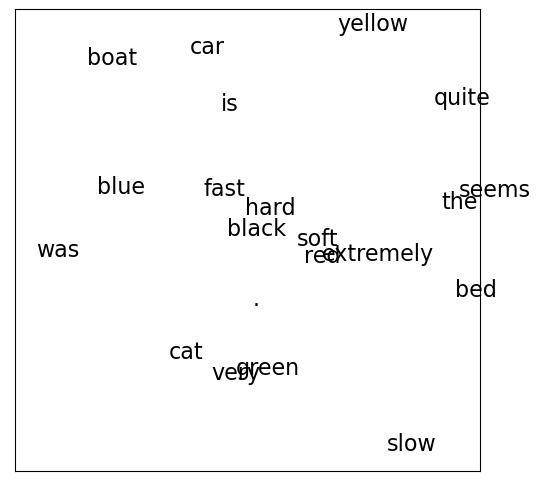

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(*zip(*transformed), marker='.', color='w')

# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
  ax.annotate(word, transformed[idx])

# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show(fig)